> ML TEAM PROJECT
>> KIM4

In [1]:
import pandas as pd
from sklearn.tree import export_graphviz # tree 시각화를 위해
import graphviz # tree 시각화
import sklearn.metrics as mt # 성능지표를 계산하기 위해 import
from sklearn.model_selection import cross_val_score, cross_validate # 교차검증
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings(action='ignore') 

pd.set_option('display.max_rows', 10)

# 데이터 크기가 너무 커서 주피터 환경에서는 not trust 상태로 변경되어 실행이 안될수도 있음
# https://stackoverflow.com/questions/44943646/jupyter-notebook-not-trusted
# 위의 링크에 해결 방법 있음


In [2]:
# 원래의 데이터는 가뭄 지수가 0과 1에 90%가량 몰려 있는 분포를 보임
# 하지만 이렇게 편향되어 있는 데이터로 학습을 진행하면
# 전체적인 accuracy는 높은 것을 확인할 수 있으나
# 가뭄 지수 4와 5에 대해서는 그냥 거의 대부분을 가뭄이 아니라고 해버림 -> 쓰레기 모델
# (= 다음 달의 가뭄지수가 높은 샘플에 대한 예측 정확도가 현저히 떨어짐을 확인함)
# 그래서 우리는 인공적으로 가뭄지수 0인 1만개의 샘플 + 가뭄지수 1인 1만개의 샘플, ...
# 이런 식으로 총 6만개(가뭄지수는 0, 1, 2, 3, 4, 5)의 샘플을 학습 데이터로 따로 생성하고
# 나중에 사용할 테스트 데이터는 편향되어 있는 데이터 셋에서 무작위로
# 가져온 샘플을 통해 테스트를 수행할 예정임


# 지금 읽어오는 데이터는 학습 데이터 구축을 위한 가뭄 지수에 대해 균일한 데이터임
# ex) 가뭄지수 0인 1만개의 샘플 + 가뭄지수 1인 1만개의 샘플, ...
df=pd.read_csv("./final_8.csv",encoding='utf-8-sig')

In [3]:
df

,Unnamed: 0.2,Unnamed: 0.1,fips,lat,lon,elevation,slope1,slope2,slope3,slope4,...,day6WS50M_MIN,day7WS50M_MIN,day1WS50M_RANGE,day2WS50M_RANGE,day3WS50M_RANGE,day4WS50M_RANGE,day5WS50M_RANGE,day6WS50M_RANGE,day7WS50M_RANGE,nextScore
0,2660456,2660456,54089,37.656003,-80.856315,555,0.0020,0.0217,0.0672,0.1527,...,2.38,7.07,5.84,3.71,3.61,5.00,4.53,4.84,2.45,0.0
1,100370,100370,5063,35.737499,-91.559942,82,0.0342,0.3045,0.3379,0.1718,...,3.51,2.35,6.54,3.20,6.07,4.45,3.58,2.74,4.22,0.0
2,1834386,1834386,39121,39.767232,-81.452604,298,0.0019,0.0124,0.0617,0.1980,...,3.91,4.33,3.82,3.92,1.77,6.30,3.57,3.74,3.22,0.0
3,744498,744498,19167,43.082854,-96.177929,414,0.0296,0.3079,0.6335,0.0290,...,1.86,6.60,5.37,5.56,8.96,3.38,11.26,11.75,10.49,0.0
4,1726751,1726751,37185,36.397979,-78.099924,100,0.0160,0.2191,0.6037,0.1571,...,0.14,2.19,2.92,4.09,5.43,4.76,1.82,5.43,3.94,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2063272,2063272,46007,43.184826,-101.676426,956,0.0967,0.4588,0.3041,0.1332,...,3.28,3.91,6.36,5.39,3.71,4.73,8.52,5.99,6.61,5.0
59996,1457257,1457257,31049,41.112988,-102.332604,1114,0.0915,0.5461,0.3135,0.0489,...,3.34,2.96,3.85,5.59,8.58,5.04,7.97,13.72,6.77,5.0
59997,299525,299525,12095,28.514435,-81.323295,29,0.0603,0.4634,0.4124,0.0622,...,2.14,3.64,6.40,1.73,1.94,4.42,4.36,5.61,2.89,5.0
59998,39899,39899,1091,32.247591,-87.791091,76,0.0188,0.2180,0.5279,0.2270,...,2.06,2.57,2.63,2.77,3.85,4.28,2.14,2.09,1.68,5.0


In [4]:
# 의미 없는 인덱스열 제거
df = df.drop(['Unnamed: 0.2'], axis = 1)
df = df.drop(['Unnamed: 0.1'], axis = 1)
df = df.drop(['Unnamed: 0'], axis = 1)

In [5]:
# 필요 없는 feature 제거
df = df.drop(['date'], axis = 1)

In [6]:
# fips의 형태가 정수형이기에 연속형 변수로 오인할수도 있음
# 하지만 fips는 우편번호를 의미하는 변수임
# 그렇기에 해당 데이터에서는 명목형 변수로 사용되었다고 볼 수 있음
# 데이터분석에서 명목형 변수를 포함시켜 분석을 수행하게 되면
# 분석 결과에 왜곡이 더해질 수 있다고 판단하여 fips를 제거함

df = df.drop(['fips'], axis = 1)

In [7]:
# 결측치가 있는지 확인
# 이를 통해 결측치가 없음을 확인했음

df.isnull().sum()

lat                0
lon                0
elevation          0
slope1             0
slope2             0
                  ..
day4WS50M_RANGE    0
day5WS50M_RANGE    0
day6WS50M_RANGE    0
day7WS50M_RANGE    0
nextScore          0
Length: 131, dtype: int64

In [8]:
# 실수형의 가뭄 지수를 정수형으로 바꿔주는 함수

def set_label(val):
    if val < 0 or val > 5:
        raise ValueError("Error: y-label should be between 0 and 5 (exclusive).")
    label = np.floor(val) 
    return label

In [9]:
# Kaggle에 나와있는 가뭄 지수에 대한 설명에 따라 ordinal data로 데이터 형태를 변환해줌
# Kaggle 가뭄지수 사진을 PPT에 보여주면서 왜 정수형으로 바꿨는지 설명할 예정

import numpy as np
df['nextScore']=df['nextScore'].apply(set_label)

In [10]:
# feature에 대한 정보 요약
# 이를 통해 잘못 조사된 정보가 없는 것을 확인함 (ex. 온도가 10000도)

pd.set_option('display.max_columns', None)
df.describe()

,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,slope7,slope8,aspectN,aspectE,aspectS,aspectW,aspectUnknown,WAT_LAND,NVG_LAND,URB_LAND,GRS_LAND,FOR_LAND,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7,score,day1PRECTOT,day2PRECTOT,day3PRECTOT,day4PRECTOT,day5PRECTOT,day6PRECTOT,day7PRECTOT,day1PS,day2PS,day3PS,day4PS,day5PS,day6PS,day7PS,day1QV2M,day2QV2M,day3QV2M,day4QV2M,day5QV2M,day6QV2M,day7QV2M,day1T2M,day2T2M,day3T2M,day4T2M,day5T2M,day6T2M,day7T2M,day1T2MDEW,day2T2MDEW,day3T2MDEW,day4T2MDEW,day5T2MDEW,day6T2MDEW,day7T2MDEW,day1T2MWET,day2T2MWET,day3T2MWET,day4T2MWET,day5T2MWET,day6T2MWET,day7T2MWET,day1T2M_MAX,day2T2M_MAX,day3T2M_MAX,day4T2M_MAX,day5T2M_MAX,day6T2M_MAX,day7T2M_MAX,day1T2M_MIN,day2T2M_MIN,day3T2M_MIN,day4T2M_MIN,day5T2M_MIN,day6T2M_MIN,day7T2M_MIN,day1T2M_RANGE,day2T2M_RANGE,day3T2M_RANGE,day4T2M_RANGE,day5T2M_RANGE,day6T2M_RANGE,day7T2M_RANGE,day1TS,day2TS,day3TS,day4TS,day5TS,day6TS,day7TS,day1WS10M_MAX,day2WS10M_MAX,day3WS10M_MAX,day4WS10M_MAX,day5WS10M_MAX,day6WS10M_MAX,day7WS10M_MAX,day1WS10M_RANGE,day2WS10M_RANGE,day3WS10M_RANGE,day4WS10M_RANGE,day5WS10M_RANGE,day6WS10M_RANGE,day7WS10M_RANGE,day1WS50M_MIN,day2WS50M_MIN,day3WS50M_MIN,day4WS50M_MIN,day5WS50M_MIN,day6WS50M_MIN,day7WS50M_MIN,day1WS50M_RANGE,day2WS50M_RANGE,day3WS50M_RANGE,day4WS50M_RANGE,day5WS50M_RANGE,day6WS50M_RANGE,day7WS50M_RANGE,nextScore
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,6.000000e+04,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,37.174419,-94.636925,525.449217,0.054209,0.305686,0.327914,0.153329,0.048629,0.062179,0.023440,0.010555,0.143398,0.170118,0.148104,0.164427,0.359895,2.099049,2.742723,2.144912,27.071252,36.299593,2.354764e+01,4.837754,28.385392,1.781350,1.491800,1.268433,1.288150,1.122183,1.103817,1.278517,2.277783,1.789942,1.928246,1.831031,1.79699,1.812865,1.721663,1.775736,95.526485,95.541485,95.54625,95.550854,95.551362,95.548472,95.537295,7.851380,7.852289,7.812284,7.738917,7.757940,7.786149,7.792411,15.324453,15.188973,15.131732,15.131106,15.130110,15.185556,15.230174,6.959916,6.942815,6.885973,6.812445,6.828249,6.849742,6.842413,7.006681,6.990770,6.93247,6.857559,6.874942,6.897906,6.890146,21.976214,21.743474,21.699069,21.752999,21.769947,21.796092,21.851514,9.344618,9.271138,9.228005,9.184247,9.171632,9.235893,9.270927,12.631575,12.472360,12.471068,12.568760,12.598298,12.560222,12.580584,15.566514,15

In [11]:
pd.set_option('display.max_columns', 20)

> 각 변수들의 히스토그램 출력

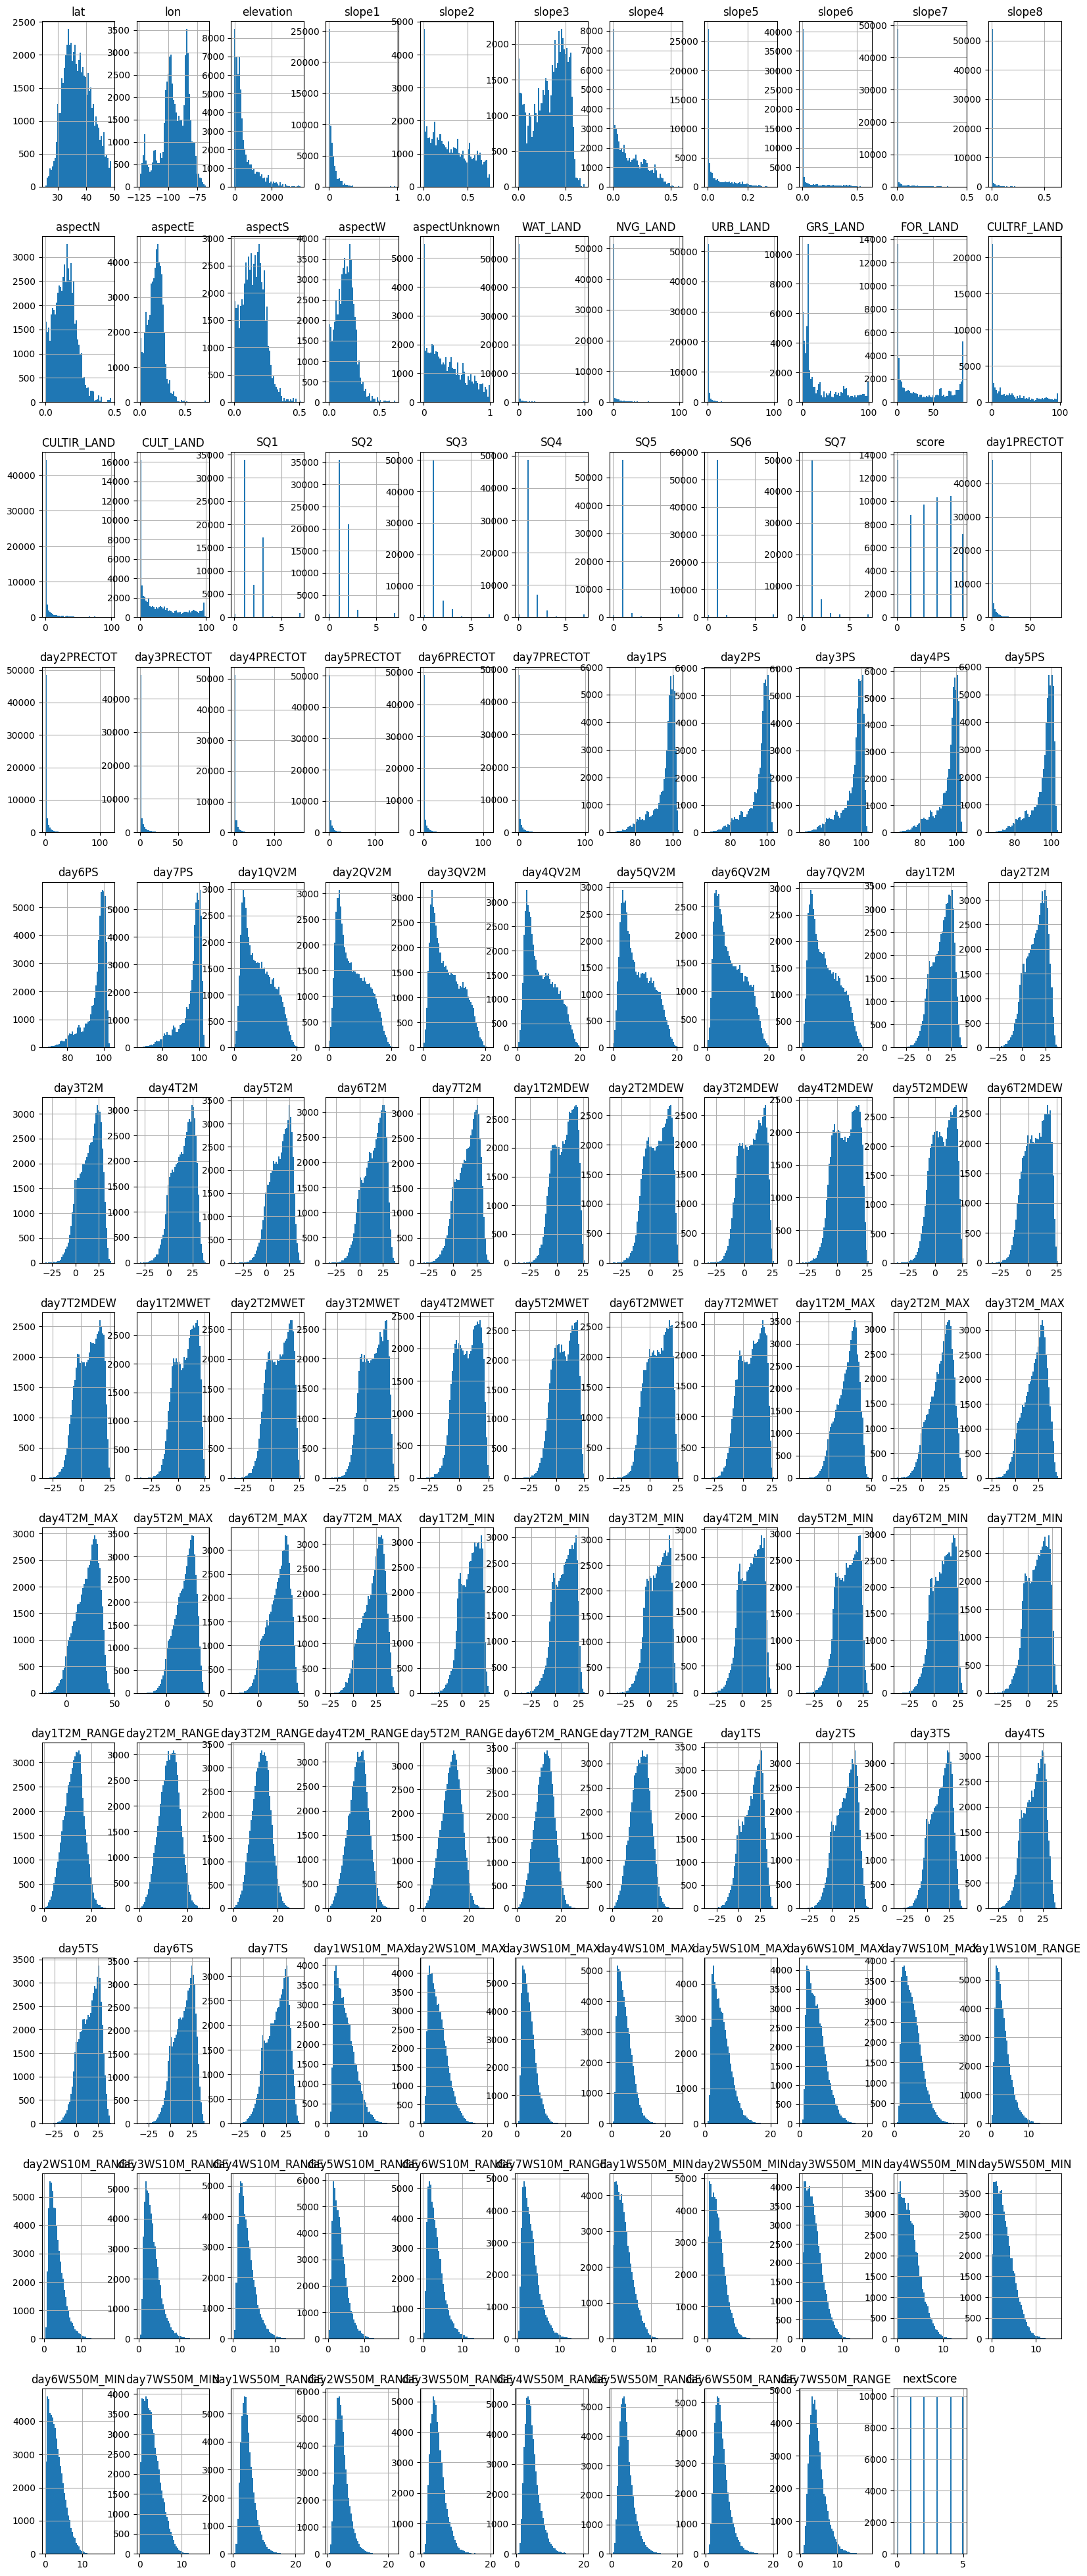

In [12]:
%matplotlib inline

# 히스토그램 사진은 따로 폴더에 저장해뒀음

# 약간의 편향이 있는 데이터가 많음을 확인함
# 그리고 편향이 존재하는 변수에 대해
# log transformation 진행 후 모델을 구축해보았으나
# 오히려 성능이 떨어지는 것을 확인하여 transformation은 진행하지 않았음
# log transformation 수행 모델과의 성능 비교는 PPT에만 넣을 예정

df.hist(bins=50, figsize=(20,50))
plt.show()

<Axes: >

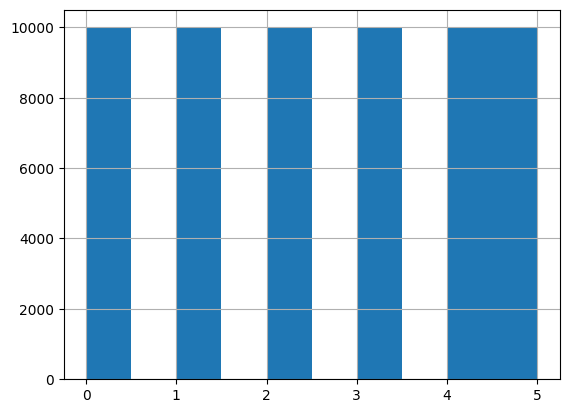

In [13]:
# nextScore는 다음달의 가뭄지수를 의미하는 변수임
# 숫자가 5에 가까워질수록 가뭄이 심한 것을 의미함
# 일부러 학습 데이터의 샘플을 가뭄지수가 균등하게 분포되도록 뽑았음

# 그 이유는 원본 데이터셋은 가뭄지수가 0과 1에 집중되어 있어
# 해당 데이터셋을 통해 학습을 진행하게 되면 전체적인 정확도는
# 높게 나오는 것을 확인했으나 
# 가뭄지수 4과 5에 대해 가뭄이 아니라고 판정하는 경우가 너무 많아짐을 확인했음 -> 쓰레기 모델
# 그래서 균일데이터로 학습을 진행하고 불균일 데이터로 테스트를 진행하기로 결정함

df['nextScore'].hist()

> Training Dataset의 전처리

In [14]:
# nextScore를 y label로 두고 분류를 수행할 예정

X = df.drop(['nextScore'], axis=1)
y = df['nextScore']

In [15]:
# nextScore를 drop한 X의 모습
X

,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,slope7,...,day5WS50M_MIN,day6WS50M_MIN,day7WS50M_MIN,day1WS50M_RANGE,day2WS50M_RANGE,day3WS50M_RANGE,day4WS50M_RANGE,day5WS50M_RANGE,day6WS50M_RANGE,day7WS50M_RANGE
0,37.656003,-80.856315,555,0.0020,0.0217,0.0672,0.1527,0.1480,0.4015,0.1702,...,4.10,2.38,7.07,5.84,3.71,3.61,5.00,4.53,4.84,2.45
1,35.737499,-91.559942,82,0.0342,0.3045,0.3379,0.1718,0.0884,0.0632,0.0000,...,3.20,3.51,2.35,6.54,3.20,6.07,4.45,3.58,2.74,4.22
2,39.767232,-81.452604,298,0.0019,0.0124,0.0617,0.1980,0.2609,0.4298,0.0353,...,0.27,3.91,4.33,3.82,3.92,1.77,6.30,3.57,3.74,3.22
3,43.082854,-96.177929,414,0.0296,0.3079,0.6335,0.0290,0.0000,0.0000,0.0000,...,2.23,1.86,6.60,5.37,5.56,8.96,3.38,11.26,11.75,10.49
4,36.397979,-78.099924,100,0.0160,0.2191,0.6037,0.1571,0.0041,0.0000,0.0000,...,3.90,0.14,2.19,2.92,4.09,5.43,4.76,1.82,5.43,3.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,43.184826,-101.676426,956,0.0967,0.4588,0.3041,0.1332,0.0072,0.0000,0.0000,...,0.38,3.28,3.91,6.36,5.39,3.71,4.73,8.52,5.99,6.61
59996,41.112988,-102.332604,1114,0.0915,0.5461,0.3135,0.0489,0.0000,0.0000,0.0000,...,5.95,3.34,2.96,3.85,5.59,8.58,5.04,7.97,13.72,6.77
59997,28.514435,-81.323295,29,0.0603,0.4634,0.4124,0.0622,0.0007,0.0010,0.0000,...,2.40,2.14,3.64,6.40,1.73,1.94,4.42,4.36,5.61,2.89
59998,32.247591,-87.791091,76,0.0188,0.2180,0.5279,0.2270,0.0082,0.0001,0.0000,...,2.65,2.06,2.57,2.63,2.77,3.85,4.28,2.14,2.09,1.68


In [16]:
# 우리가 지금 사용하는 데이터 셋에서 LAND 변수가 어떻게 생겼냐면
# CULTRF_LAND + CULTIR_LAND = CULT_LAND
# CULT_LAND + WAT_LAND + NVG_LAND + URB_LAND + GRS_LAND + FOR_LAND = 100
# 이런 식으로 되어있음 -> 독립변수간의 상관관계가 높기 때문에 다중공선성 문제 발생할 것이라고 생각했음
# 그래서 CULTRF_LAND랑 CULTIR_LAND는 학습과 분석에서 제외하고
# CULT_LAND, WAT_LAND, NVG_LAND, URB_LAND, GRS_LAND, FOR_LAND 이 변수만 pca를 통해 사용할 예정임

X = X.drop(['CULTRF_LAND', 'CULTIR_LAND'], axis = 1)

In [17]:
# slope는 다중공선성 문제가 발생하는 변수임 - PPT에서 추가 설명
# aspect는 다중공선성 문제가 발생하는 변수임
# aspect 변수는 aspectN, aspectE, aspectS, aspect, aspectUnknown의 총 합이 1
# *_LAND는 다중공선성 문제가 발생하는 변수임

# 다중공선성 문제를 해결하기 위해 pca를 통해 여러 변수들을
# 하나의 변수로 만들 예정임

slope_df = X[['slope1', 'slope2', 'slope3', 'slope4', 'slope5', 'slope6', 'slope7', 'slope8']]
land_df = X[['CULT_LAND', 'WAT_LAND', 'NVG_LAND', 'URB_LAND', 'GRS_LAND', 'FOR_LAND']]
aspect_df = X[['aspectN', 'aspectE', 'aspectW', 'aspectS', 'aspectUnknown']]

In [18]:
# 다중공선성 문제가 발생하는 변수를 모두 삭제함

X = X.drop(['slope1', 'slope2', 'slope3', 'slope4', 'slope5', 'slope6', 'slope7', 'slope8'], axis = 1)
X = X.drop(['CULT_LAND', 'WAT_LAND', 'NVG_LAND', 'URB_LAND', 'GRS_LAND', 'FOR_LAND'], axis = 1)
X = X.drop(['aspectN', 'aspectE', 'aspectW', 'aspectS', 'aspectUnknown'], axis = 1)

In [19]:
# 차원 축소를 통해 slope 변수를 하나로 합침 -> 다중공선성 문제 해결
pca = PCA(n_components=1)
pca_result = pca.fit_transform(slope_df)
pca_result

# 차원 축소한 slope 변수를 다시 데이터프레임에 넣어줌
X['slope'] = pca_result

In [20]:
# 차원 축소를 통해 *_LAND 변수를 하나로 합침 -> 다중공선성 문제 해결
pca = PCA(n_components=1)
pca_result = pca.fit_transform(land_df)
pca_result

# 차원 축소한 LAND 변수를 다시 데이터프레임에 넣어줌
X['LAND'] = pca_result

In [21]:
# 차원 축소를 통해 aspect 변수를 하나로 합침 -> 다중공선성 문제 해결
pca = PCA(n_components=1)
pca_result = pca.fit_transform(aspect_df)
pca_result

# 차원 축소한 aspect 변수를 다시 데이터프레임에 넣어줌
X['aspect'] = pca_result

---

> Test Dataset의 전처리

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
# test_df는 불균일 데이터임
# 웬만하면 가뭄지수가 0이거나 1임 (원본 데이터)
# 학습데이터를 균일 데이터로 쓴 이유는 따로 설명할 예정임

test_df=pd.read_csv("./final_8_test20000.csv",encoding='utf-8-sig')

In [24]:
# 의미 없는 인덱스열 제거
test_df = test_df.drop(['Unnamed: 0.2'], axis = 1)
test_df = test_df.drop(['Unnamed: 0.1'], axis = 1)
test_df = test_df.drop(['Unnamed: 0'], axis = 1)

In [25]:
# 필요 없는 feature 제거
test_df = test_df.drop(['date'], axis = 1)

In [26]:
# fips의 형태가 정수형이기에 연속형 변수로 오인할수도 있음
# 하지만 fips는 우편번호를 의미하는 변수임
# 그렇기에 해당 데이터에서는 명목형 변수로 사용되었다고 볼 수 있음
# 데이터분석에서 명목형 변수를 포함시켜 분석을 수행하게 되면
# 분석 결과에 왜곡이 더해질 수 있다고 판단하여 fips를 제거함

test_df = test_df.drop(['fips'], axis = 1)

In [27]:
# nextScore를 y label로 두고 회귀분석을 수행할 예정

test_X = test_df.drop(['nextScore'], axis=1)
test_y = test_df['nextScore']

In [28]:
# 우리가 지금 사용하는 데이터 셋에서 LAND 변수가 어떻게 생겼냐면
# CULTRF_LAND + CULTIR_LAND = CULT_LAND
# CULT_LAND + WAT_LAND + NVG_LAND + URB_LAND + GRS_LAND + FOR_LAND = 100
# 이런 식으로 되어있음 -> 독립변수간의 상관관계가 높기 때문에 다중공선성 문제 발생할 것이라고 생각했음
# 그래서 CULTRF_LAND랑 CULTIR_LAND는 학습과 분석에서 제외하고
# CULT_LAND, WAT_LAND, NVG_LAND, URB_LAND, GRS_LAND, FOR_LAND 이 변수만 pca를 통해 사용할 예정임

test_X = test_X.drop(['CULTRF_LAND', 'CULTIR_LAND'], axis = 1)

In [29]:
# slope는 다중공선성 문제가 발생하는 변수임 - PPT에서 추가 설명
# aspect는 다중공선성 문제가 발생하는 변수임
# aspect 변수는 aspectN, aspectE, aspectS, aspect, aspectUnknown의 총 합이 1
# *_LAND는 다중공선성 문제가 발생하는 변수임

# 다중공선성 문제를 해결하기 위해 pca를 통해 여러 변수들을
# 하나의 변수로 만들 예정임

slope_df = test_X[['slope1', 'slope2', 'slope3', 'slope4', 'slope5', 'slope6', 'slope7', 'slope8']]
land_df = test_X[['CULT_LAND', 'WAT_LAND', 'NVG_LAND', 'URB_LAND', 'GRS_LAND', 'FOR_LAND']]
aspect_df = test_X[['aspectN', 'aspectE', 'aspectW', 'aspectS', 'aspectUnknown']]

In [30]:
# 다중공선성 문제가 발생하는 변수를 모두 삭제함

test_X = test_X.drop(['slope1', 'slope2', 'slope3', 'slope4', 'slope5', 'slope6', 'slope7', 'slope8'], axis = 1)
test_X = test_X.drop(['CULT_LAND', 'WAT_LAND', 'NVG_LAND', 'URB_LAND', 'GRS_LAND', 'FOR_LAND'], axis = 1)
test_X = test_X.drop(['aspectN', 'aspectE', 'aspectW', 'aspectS', 'aspectUnknown'], axis = 1)

In [31]:
# 차원 축소를 통해 slope 변수를 하나로 합침 -> 다중공선성 문제 해결
pca = PCA(n_components=1)
pca_result = pca.fit_transform(slope_df)
pca_result

# 차원 축소한 slope 변수를 다시 데이터프레임에 넣어줌
test_X['slope'] = pca_result

In [32]:
# 차원 축소를 통해 *_LAND 변수를 하나로 합침 -> 다중공선성 문제 해결
pca = PCA(n_components=1)
pca_result = pca.fit_transform(land_df)
pca_result

# 차원 축소한 LAND 변수를 다시 데이터프레임에 넣어줌
test_X['LAND'] = pca_result

In [33]:
# 차원 축소를 통해 aspect 변수를 하나로 합침 -> 다중공선성 문제 해결
pca = PCA(n_components=1)
pca_result = pca.fit_transform(aspect_df)
pca_result

# 차원 축소한 aspect 변수를 다시 데이터프레임에 넣어줌
test_X['aspect'] = pca_result

> Validation Dataset과 Test Dataset 각각의 샘플의 수는 10,000개

In [34]:
# test_df를 반반으로 나눠서 사용할 예정임
# validation dataset, test dataset의 비율
# 5:5 비율

test= 0.5

In [35]:
validation_X, test_X, validation_Y, test_Y = train_test_split(test_X, test_y, test_size=(test), random_state = 42)

In [36]:
train_X = X
train_Y = y

In [37]:
# test 데이터셋의 nextScore(다음달 가뭄지수) 비율
# 불균일 데이터임을 확인할 수 있다

test_df['nextScore'].value_counts() / len(df)

nextScore
0.0    0.653750
1.0    0.153067
2.0    0.095550
3.0    0.061100
4.0    0.029033
5.0    0.007500
Name: count, dtype: float64

> Exploratory Data Analysis(EDA)

Text(0.5, 1.0, 'lon - lat')

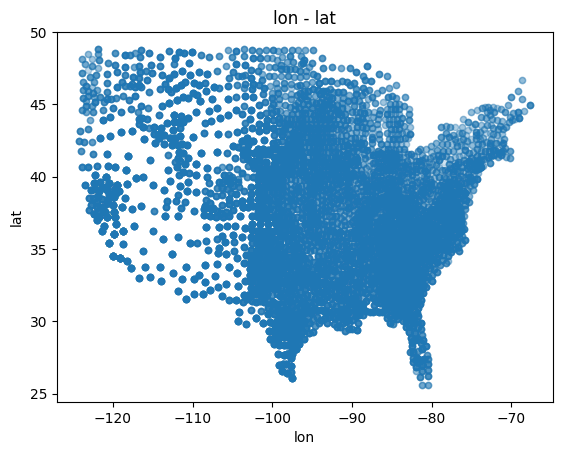

In [38]:
# 위도와 경도로 scatter 찍어보기
df.plot.scatter(x="lon", y="lat", alpha=0.1)
plt.title("lon - lat")

# 주로 미국 동부의 데이터가 많음을 확인했음

In [39]:
df_matrix = df.corr()

In [40]:
# 임시로 행 제한 없애서 상관관계 다 보여줌
pd.set_option('display.max_rows', None)
df_matrix['nextScore'].sort_values(ascending=False)

nextScore          1.000000
score              0.906744
day4T2M_MAX        0.270651
day1T2M_MAX        0.268135
day3T2M_MAX        0.266861
day1T2M_RANGE      0.265792
day7T2M_RANGE      0.263533
day5T2M_MAX        0.262128
day7T2M_MAX        0.261362
day4T2M_RANGE      0.259140
day6T2M_MAX        0.258741
day2T2M_MAX        0.256874
day3T2M_RANGE      0.248701
day5T2M_RANGE      0.248125
day6T2M_RANGE      0.248011
day4TS             0.239109
day1TS             0.237637
day3TS             0.237013
day5TS             0.234196
day4T2M            0.233532
day2TS             0.232519
day1T2M            0.231138
day3T2M            0.230998
day6TS             0.230920
day2T2M_RANGE      0.230448
day7TS             0.230076
day5T2M            0.227375
day2T2M            0.225646
day6T2M            0.224337
day7T2M            0.223695
day4T2M_MIN        0.202028
day3T2M_MIN        0.201286
GRS_LAND           0.200668
day2T2M_MIN        0.198808
day1T2M_MIN        0.198430
day5T2M_MIN        0

In [41]:
pd.set_option('display.max_rows', 10)

array([[<Axes: xlabel='WAT_LAND', ylabel='WAT_LAND'>,
        <Axes: xlabel='NVG_LAND', ylabel='WAT_LAND'>,
        <Axes: xlabel='URB_LAND', ylabel='WAT_LAND'>,
        <Axes: xlabel='GRS_LAND', ylabel='WAT_LAND'>,
        <Axes: xlabel='CULTRF_LAND', ylabel='WAT_LAND'>,
        <Axes: xlabel='CULTIR_LAND', ylabel='WAT_LAND'>,
        <Axes: xlabel='CULT_LAND', ylabel='WAT_LAND'>],
       [<Axes: xlabel='WAT_LAND', ylabel='NVG_LAND'>,
        <Axes: xlabel='NVG_LAND', ylabel='NVG_LAND'>,
        <Axes: xlabel='URB_LAND', ylabel='NVG_LAND'>,
        <Axes: xlabel='GRS_LAND', ylabel='NVG_LAND'>,
        <Axes: xlabel='CULTRF_LAND', ylabel='NVG_LAND'>,
        <Axes: xlabel='CULTIR_LAND', ylabel='NVG_LAND'>,
        <Axes: xlabel='CULT_LAND', ylabel='NVG_LAND'>],
       [<Axes: xlabel='WAT_LAND', ylabel='URB_LAND'>,
        <Axes: xlabel='NVG_LAND', ylabel='URB_LAND'>,
        <Axes: xlabel='URB_LAND', ylabel='URB_LAND'>,
        <Axes: xlabel='GRS_LAND', ylabel='URB_LAND'>,
        <Axe

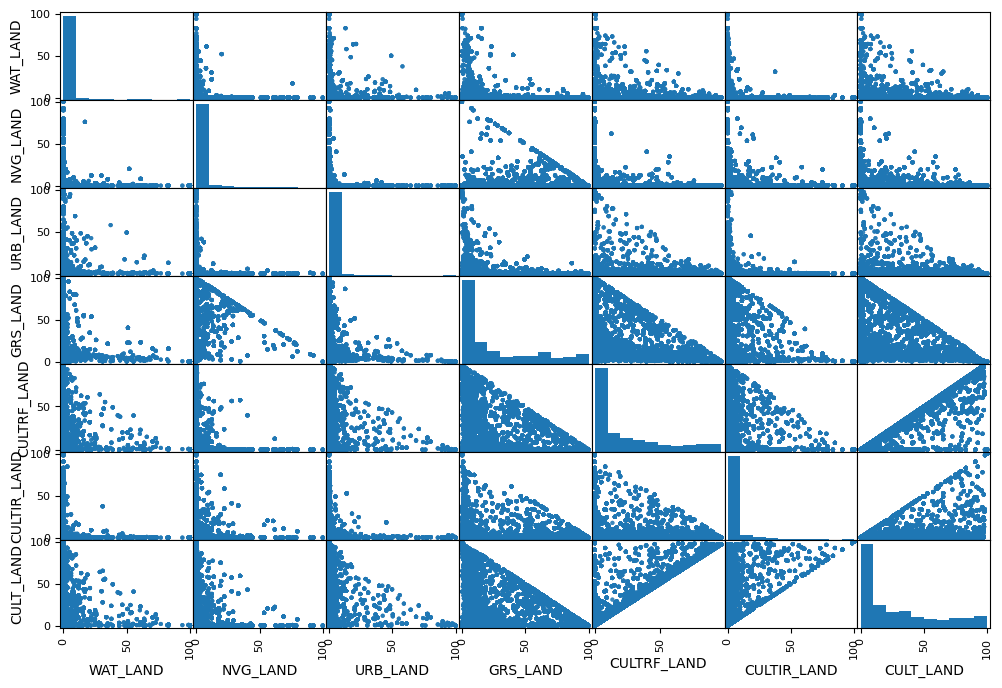

In [43]:
# *_LAND의 총 합은 100임
# trade-off 관계성을 식별함

from pandas.plotting import scatter_matrix

attributes = ["WAT_LAND", "NVG_LAND", "URB_LAND", "GRS_LAND", "CULTRF_LAND", "CULTIR_LAND", "CULT_LAND"]
scatter_matrix(df[attributes], figsize=(12, 8))

# Modeling

In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
forest = RandomForestClassifier(criterion='gini',
                           n_estimators=100,
                           random_state=40)
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split


In [45]:
# Random Forest

# 랜덤 포레스트 분류 모델 생성 및 훈련
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=40, n_jobs = -1)
random_forest_model.fit(train_X, train_Y)

# 테스트 데이터로 예측 수행
pred_Y = random_forest_model.predict(test_X)

# 분류 모델의 성능 평가
print(classification_report(test_Y, pred_Y))

              precision    recall  f1-score   support

         0.0       0.93      0.81      0.87     19647
         1.0       0.41      0.54      0.47      4564
         2.0       0.47      0.57      0.52      2831
         3.0       0.59      0.65      0.62      1806
         4.0       0.64      0.72      0.68       913
         5.0       0.55      0.94      0.70       239

    accuracy                           0.74     30000
   macro avg       0.60      0.71      0.64     30000
weighted avg       0.77      0.74      0.75     30000



 1) lat                            0.018099
 2) lon                            0.016101
 3) day1T2M_RANGE                  0.010453
 4) day7T2M_RANGE                  0.010364
 5) day7T2M_MAX                    0.010222
 6) day6T2M_MAX                    0.009917
 7) day4T2M_RANGE                  0.009508
 8) day2T2M_MAX                    0.009293
 9) day4T2M_MAX                    0.009233
10) day5T2M_RANGE                  0.009125
11) day6T2M_RANGE                  0.009096
12) day1T2M_MAX                    0.009078
13) day2T2M_RANGE                  0.009044
14) day3T2M_RANGE                  0.008694
15) day3T2M_MAX                    0.008402
16) elevation                      0.008395
17) LAND                           0.008364
18) day1PS                         0.008346
19) day3PS                         0.008263
20) day1TS                         0.008254
21) day7WS50M_MIN                  0.008213
22) day1WS50M_MIN                  0.008198
23) day5T2M_MAX                 

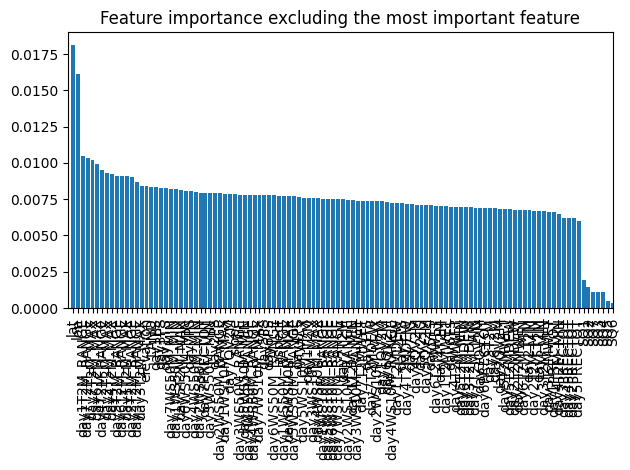

In [46]:
feat_labels = train_X.columns

#randomforest모델에서 특성중요도를 가져와서 import 변수에 저장
importances = random_forest_model.feature_importances_
indices = np.argsort(importances)[::-1]

# 첫 번째 중요한 특성 제외(score가 미치는 영향력이 너무커서 시각화통해 모델에 대한 해석력이 떨어지므로 제거함)
indices = indices[1:]

# 중요도 값 및 변수 이름 출력
for f in range(len(indices)):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

# 특성 중요도 시각화
plt.title("Feature importance excluding the most important feature")
plt.bar(range(len(indices)), importances[indices], align='center')
plt.xticks(range(len(indices)), [feat_labels[i] for i in indices], rotation=90)
plt.xlim([-1, len(indices)-1])
plt.tight_layout()
plt.show()


In [47]:
# AdaBoost


from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score


# AdaBoost 분류 모델 생성 및 훈련
clf = AdaBoostClassifier(n_estimators=100, 
                        random_state=40, 
                        learning_rate=0.01)
clf.fit(train_X, train_Y)
pred_Y = clf.predict(test_X)

# 분류 모델의 성능 평가
print(classification_report(test_Y, pred_Y))

              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90     19647
         1.0       0.47      0.46      0.46      4564
         2.0       0.51      0.52      0.52      2831
         3.0       0.57      0.58      0.58      1806
         4.0       0.00      0.00      0.00       913
         5.0       0.20      0.95      0.33       239

    accuracy                           0.75     30000
   macro avg       0.44      0.57      0.46     30000
weighted avg       0.74      0.75      0.75     30000



In [ ]:
#GradientBoosting

# GradientBoosting 분류 모델 생성 및 훈련
gbm = GradientBoostingClassifier(n_estimators=100,
                                learning_rate = 0.01,
                                random_state=40)

gbm.fit(train_X, train_Y)

# 테스트 데이터로 예측 수행
pred_Y = gbm.predict(test_X)

# 분류 모델의 성능 평가
print(classification_report(test_Y, pred_Y))

              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90     19647
         1.0       0.47      0.46      0.46      4564
         2.0       0.51      0.53      0.52      2831
         3.0       0.57      0.58      0.58      1806
         4.0       0.62      0.60      0.61       913
         5.0       0.63      0.64      0.64       239

    accuracy                           0.77     30000
   macro avg       0.62      0.62      0.62     30000
weighted avg       0.77      0.77      0.77     30000



In [48]:
# XGBClassifier

# XGBClassifier 분류 모델 생성 및 훈련
xgb =  XGBClassifier(n_estimators=100,
                     learning_rate = 0.01,
                     random_state=40, n_jobs = -1)
xgb .fit(train_X, train_Y)
pred_Y = xgb .predict(test_X)
# 분류 모델의 성능 평가
print(classification_report(test_Y, pred_Y))

              precision    recall  f1-score   support

         0.0       0.91      0.88      0.89     19647
         1.0       0.45      0.47      0.46      4564
         2.0       0.50      0.54      0.52      2831
         3.0       0.59      0.55      0.57      1806
         4.0       0.57      0.56      0.57       913
         5.0       0.43      0.83      0.57       239

    accuracy                           0.76     30000
   macro avg       0.58      0.64      0.60     30000
weighted avg       0.77      0.76      0.76     30000



 1) day3T2MWET                     0.071828
 2) day7T2M_MAX                    0.023192
 3) day2T2M_MAX                    0.016654
 4) day4T2M_MAX                    0.016082
 5) day6T2M_MAX                    0.014444
 6) day7T2M                        0.014061
 7) day2TS                         0.010485
 8) lon                            0.010217
 9) day4T2MDEW                     0.010022
10) day1T2M_MAX                    0.009501
11) lat                            0.009219
12) day5T2M_MAX                    0.009120
13) day2T2MDEW                     0.008854
14) day3T2M                        0.007490
15) day5T2M                        0.007330
16) day1T2M                        0.007050
17) day2T2M                        0.005967
18) day7PRECTOT                    0.005896
19) day5T2M_MIN                    0.005789
20) SQ2                            0.005491
21) day5TS                         0.005432
22) day4T2M                        0.005306
23) day2T2M_MIN                 

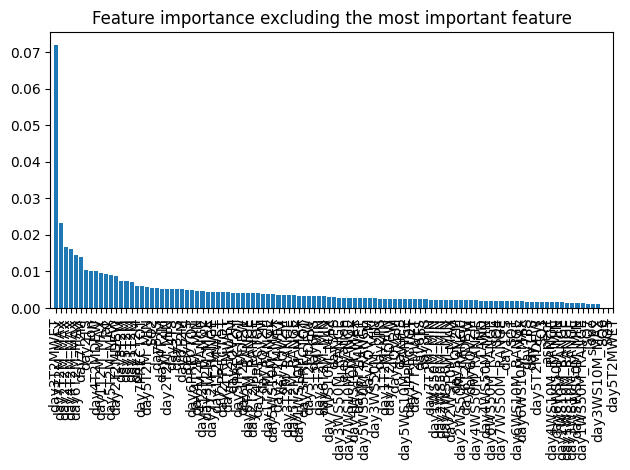

In [49]:
feat_labels = train_X.columns
#XGBClassifier모델에서 특성중요도를 가져와서 importances 변수에 저장
importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1]

# 첫 번째 중요한 특성 제외(score가 미치는 영향력이 너무커서 시각화통해 모델에 대한 해석력이 떨어지므로 제거함)
indices = indices[1:]

# 중요도 값 및 변수 이름 출력
for f in range(len(indices)):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

# 특성 중요도 시각화
plt.title("Feature importance excluding the most important feature")
plt.bar(range(len(indices)), importances[indices], align='center')
plt.xticks(range(len(indices)), [feat_labels[i] for i in indices], rotation=90)
plt.xlim([-1, len(indices)-1])
plt.tight_layout()
plt.show()


In [50]:
# LGBMClassifier

# LGBMClassifier 분류 모델 생성 및 훈련
lgb = LGBMClassifier(n_estimators=500,
                     learning_rate = 0.1,
                     random_state=40)
lgb .fit(train_X, train_Y)
pred_Y = lgb .predict(test_X)
# 분류 모델의 성능 평가
print(classification_report(test_Y, pred_Y))

              precision    recall  f1-score   support

         0.0       0.93      0.83      0.88     19647
         1.0       0.42      0.54      0.47      4564
         2.0       0.50      0.59      0.54      2831
         3.0       0.60      0.63      0.61      1806
         4.0       0.66      0.70      0.68       913
         5.0       0.59      0.93      0.72       239

    accuracy                           0.75     30000
   macro avg       0.62      0.70      0.65     30000
weighted avg       0.78      0.75      0.76     30000



 1) score                          2320.000000
 2) lon                            2241.000000
 3) lat                            2139.000000
 4) day1T2M_RANGE                  1486.000000
 5) day7T2M_RANGE                  1441.000000
 6) day7WS50M_MIN                  1431.000000
 7) day4T2M_RANGE                  1394.000000
 8) day7WS50M_RANGE                1350.000000
 9) day3T2M_RANGE                  1347.000000
10) LAND                           1347.000000
11) day6WS50M_MIN                  1346.000000
12) day6T2M_RANGE                  1342.000000
13) day2T2M_RANGE                  1340.000000
14) day1WS50M_MIN                  1331.000000
15) day3WS50M_MIN                  1331.000000
16) day7PRECTOT                    1325.000000
17) day3WS50M_RANGE                1314.000000
18) day5WS50M_MIN                  1312.000000
19) day2WS50M_MIN                  1286.000000
20) day6WS50M_RANGE                1285.000000
21) day5T2M_RANGE                  1283.000000
22) day4WS50M

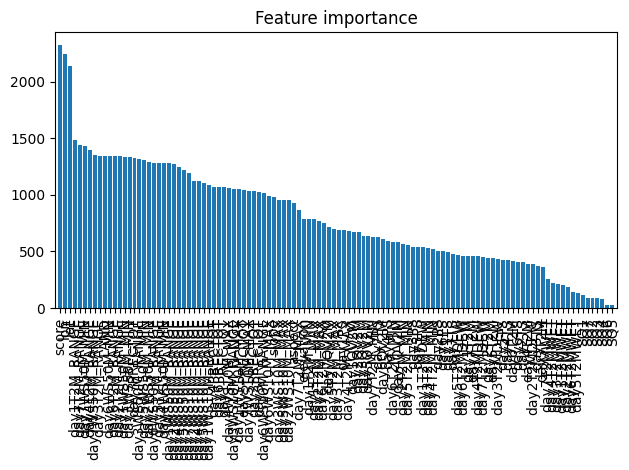

In [51]:
feat_labels = train_X.columns

#LGBMClassifier모델에서 특성중요도를 가져와서 import 변수에 저장
importances = lgb.feature_importances_

#특성의 중요도가 높은 특성이 먼저 나오게 변환
indices = np.argsort(importances)[::-1]

for f in range(train_X.shape[1]):
    print("%2d) %-*s %f"%(f+1, 30, feat_labels[indices[f]],
                         importances[indices[f]]))

#변수 중요도를 시각화
plt.title("Feature importance")
plt.bar(range(train_X.shape[1]),
             importances[indices],
             align='center')
plt.xticks(range(train_X.shape[1]),
          feat_labels[indices], rotation=90)
plt.xlim([-1, train_X.shape[1]])
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, AdaBoostClassifier

In [ ]:
#stacking
# 기본 모델
level0 = list()
#기본 모델을 XGBClassifier, AdaBoostClassifier, RandomForestClassifier을 사용
#기본 모델을 3개 사용함으로써, 일반화 성능을 높이고 최종 모델을 견고하게 한다.
level0.append(('xgb', XGBClassifier(n_estimators=100,
                                    learning_rate = 0.01,
                                    random_state=40, n_jobs = -1)))
level0.append(('clf', AdaBoostClassifier(n_estimators=100, learning_rate=0.01, random_state=40)))
level0.append(('random_forest', RandomForestClassifier(n_estimators=100, criterion='gini', random_state=40,n_jobs=-1)))

# 최종 모델
# 최종 분석모델을 XGBClassifier을 사용
level1 = XGBClassifier(n_estimators=100,
                      learning_rate=0.01,
                      random_state=40, n_jobs=-1)

# stacking 분류 모델 생성 및 훈련
model = StackingClassifier(estimators=level0, final_estimator=level1, n_jobs=-1)
# 스태킹 모델 학습
model.fit(train_X, train_Y)
# 스태킹 모델 예측 수행
pred_Y = model.predict(test_X)
# 분류 모델의 성능 평가
print(classification_report(test_Y, pred_Y))

              precision    recall  f1-score   support

         0.0       0.93      0.85      0.89     19647
         1.0       0.46      0.54      0.50      4564
         2.0       0.52      0.60      0.56      2831
         3.0       0.63      0.65      0.64      1806
         4.0       0.65      0.74      0.69       913
         5.0       0.63      0.94      0.75       239

    accuracy                           0.77     30000
   macro avg       0.64      0.72      0.67     30000
weighted avg       0.79      0.77      0.78     30000



In [ ]:
#stacking
# 기본 모델
level0 = list()
#기본 모델을 XGBClassifier, LGBMClassifier, RandomForestClassifier을 사용
#기본 모델을 3개 사용함으로써, 일반화 성능을 높이고 최종 모델을 견고하게 한다.
level0.append(('xgb', XGBClassifier(n_estimators=100,
                                    learning_rate = 0.01,
                                    random_state=40, n_jobs = -1)))
level0.append(('lgb', LGBMClassifier(n_estimators=100, learning_rate = 0.01, random_state=40)))
level0.append(('random_forest', RandomForestClassifier(n_estimators=100, criterion='gini', random_state=40,n_jobs=-1)))

# 최종 모델
# 최종 분석 모델을 XGBClassifier을 사용
level1 = XGBClassifier(n_estimators=100,
                      learning_rate=0.01,
                      random_state=40, n_jobs=-1)

# stacking 분류 모델 생성 및 훈련
model = StackingClassifier(estimators=level0, final_estimator=level1, n_jobs=-1)
# 스태킹 모델 학습
model.fit(train_X, train_Y)
# 스태킹 모델 예측 수행
pred_Y = model.predict(test_X)
# 분류 모델의 성능 평가
print(classification_report(test_Y, pred_Y))

              precision    recall  f1-score   support

         0.0       0.93      0.86      0.89     19647
         1.0       0.46      0.54      0.50      4564
         2.0       0.52      0.60      0.56      2831
         3.0       0.63      0.66      0.64      1806
         4.0       0.66      0.74      0.70       913
         5.0       0.63      0.94      0.75       239

    accuracy                           0.77     30000
   macro avg       0.64      0.72      0.67     30000
weighted avg       0.79      0.77      0.78     30000



In [ ]:
# stacking
# 기본 모델
level0 = list()
# 기본 모델을 XGBClassifier, AdaBoostClassifier, RandomForestClassifier을 사용
# 기본 모델을 3개 사용함으로써, 일반화 성능을 높이고 최종 모델을 견고하게 한다.
level0.append(('xgb', XGBClassifier(n_estimators=100,
                                    learning_rate = 0.01,
                                    random_state=40, n_jobs = -1)))
level0.append(('lgb', LGBMClassifier(n_estimators=100, learning_rate = 0.01, random_state=40)))
level0.append(('random_forest', RandomForestClassifier(n_estimators=100, criterion='gini', random_state=40,n_jobs=-1)))

# 최종 모델
# 최종 분석 모델을 LGBMClassifier을 사용
level1 = LGBMClassifier(n_estimators=100,
                     learning_rate = 0.01,
                     random_state=40)

# stacking 분류 모델 생성 및 훈련
model = StackingClassifier(estimators=level0, final_estimator=level1, n_jobs=-1)
# 스태킹 모델 학습
model.fit(train_X, train_Y)
# 스태킹 모델 예측 수행
pred_Y = model.predict(test_X)
# 분류 모델의 성능 평가
print(classification_report(test_Y, pred_Y))

              precision    recall  f1-score   support

         0.0       0.93      0.85      0.89     19647
         1.0       0.46      0.55      0.50      4564
         2.0       0.53      0.61      0.56      2831
         3.0       0.63      0.65      0.64      1806
         4.0       0.66      0.75      0.70       913
         5.0       0.63      0.94      0.75       239

    accuracy                           0.77     30000
   macro avg       0.64      0.72      0.67     30000
weighted avg       0.79      0.77      0.78     30000



## eXplainable AI(Shap)

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [121]:
# 데이터에 대한 처리속도가 너무 느려져서 0.1만큼만 사용하여 분석 진행
sample_train_X = train_X.sample(frac=0.1)
sample_test_X = test_X.sample(frac=0.1)

In [ ]:
# random_forest_model에 대한 shap explainer을 생성하여 shap  value 계산
# 계산 속도를 빠르게 하기 위해서 apppoximate, n_jobs를 사용
explainer = shap.TreeExplainer(random_forest_model, approximate=True,n_jobs=-1)

In [ ]:
#훈련 데이터의 각 특성에 대한 SHAP 값들을 계산
shap_values_train = explainer.shap_values(sample_train_X)

In [ ]:
#결과 데이터의 각 특성에 대한 SHAP 값들을 계산
shap_values_test = explainer.shap_values(sample_test_X)

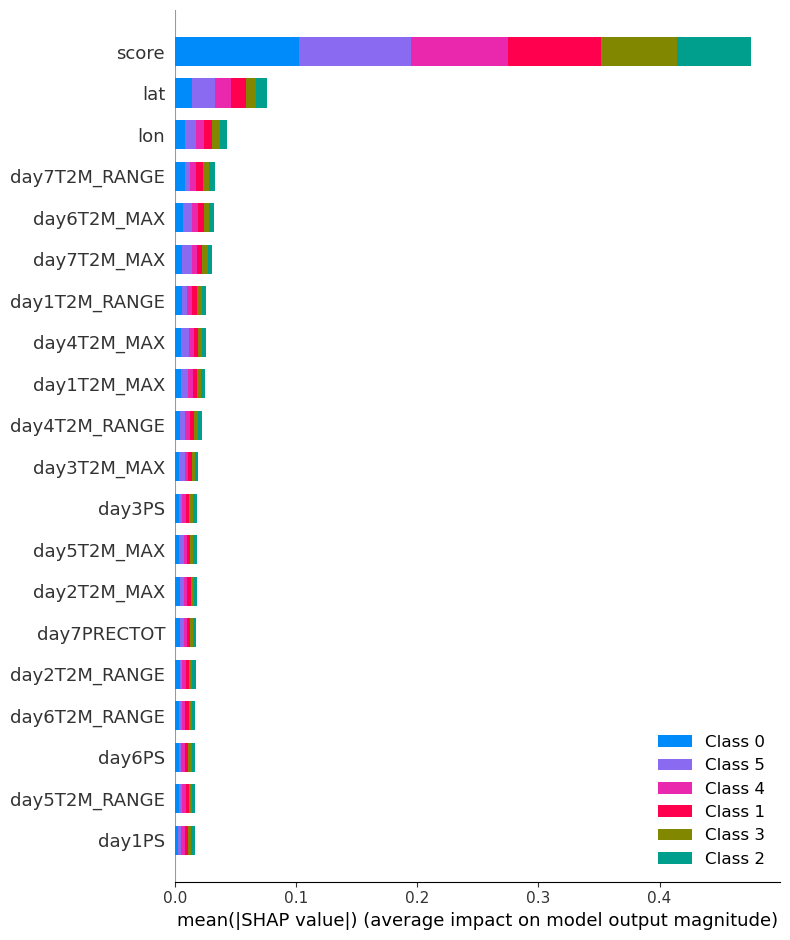

In [ ]:
# 학습데이터 summary_plot
shap.summary_plot(shap_values_train, sample_train_X)

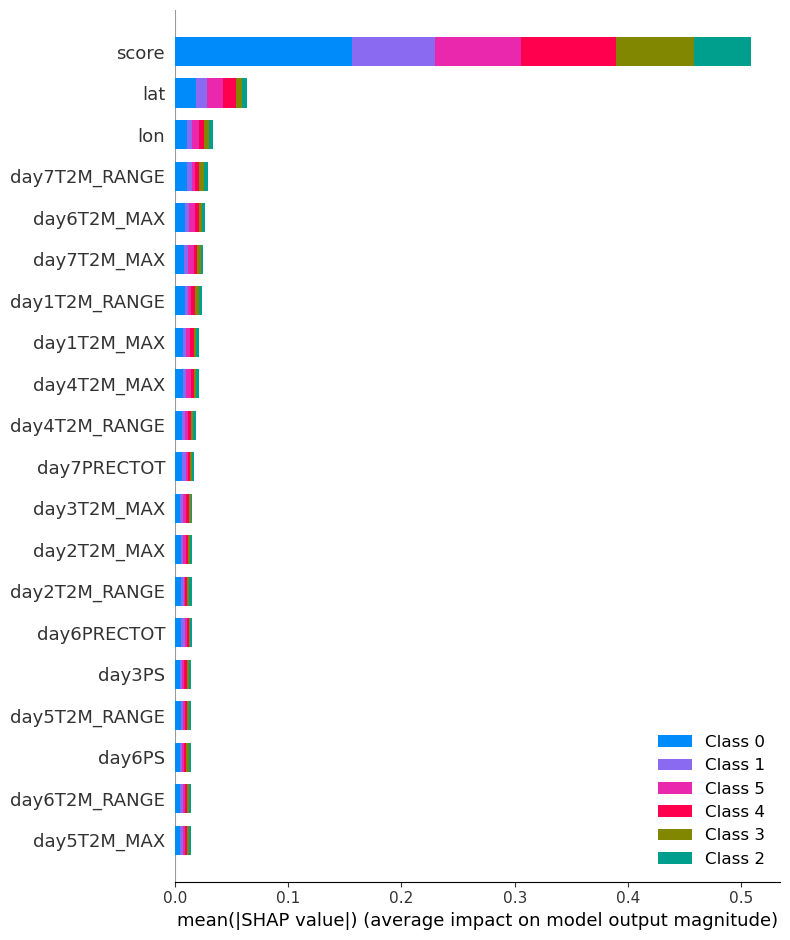

In [ ]:
# test 데이터 summary_plot
shap.summary_plot(shap_values_test, sample_test_X)

In [53]:
# XGBClassifier에 대한 shap explainer을 생성하여 shap  value 계산
#계산 속도를 빠르게 하기 위해서 apppoximate, n_jobs를 사용
explainer = shap.TreeExplainer(xgb, approximate=True,n_jobs=-1)

In [54]:
#훈련 데이터의 각 특성에 대한 SHAP 값들을 계산
shap_values_train = explainer.shap_values(train_X)

In [55]:
#결과 데이터의 각 특성에 대한 SHAP 값들을 계산
shap_values_test = explainer.shap_values(test_X)

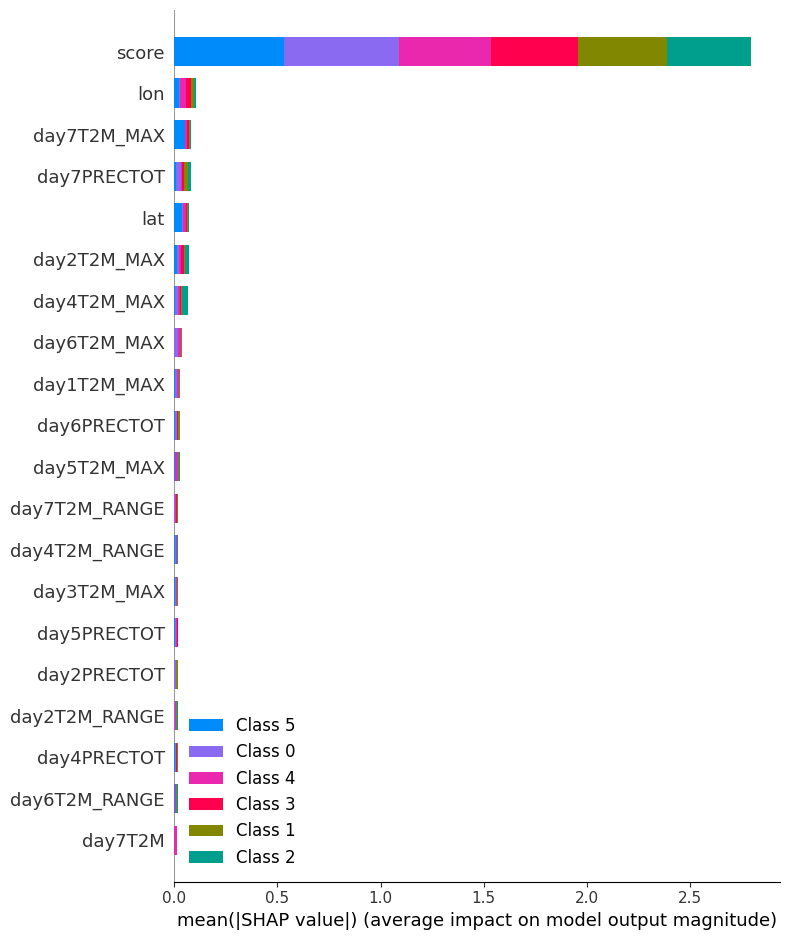

In [56]:
# 학습데이터 summary_plot
shap.summary_plot(shap_values_train, train_X)

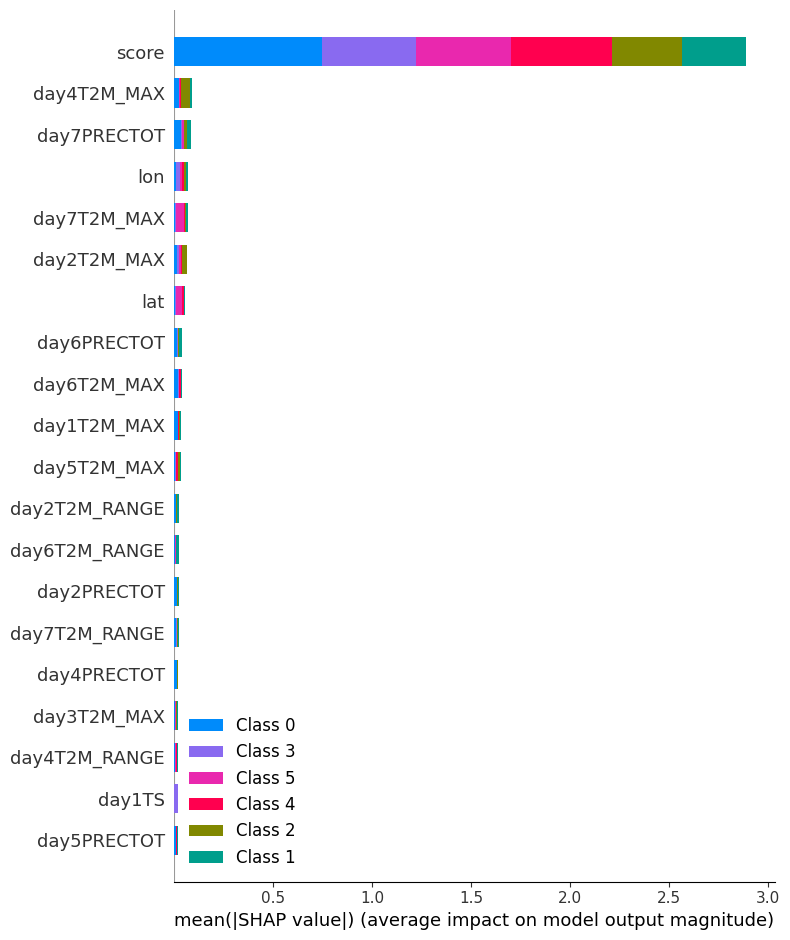

In [57]:
# test 데이터 summary_plot
shap.summary_plot(shap_values_test, test_X)

In [58]:
# LGBMClassifier에 대한 shap explainer을 생성하여 shap  value 계산
#계산 속도를 빠르게 하기 위해서 apppoximate, n_jobs를 사용
explainer = shap.TreeExplainer(lgb, approximate=True,n_jobs=-1)

In [59]:
#훈련 데이터의 각 특성에 대한 SHAP 값들을 계산
shap_values_train = explainer.shap_values(train_X)

In [60]:
#결과 데이터의 각 특성에 대한 SHAP 값들을 계산
shap_values_test = explainer.shap_values(test_X)

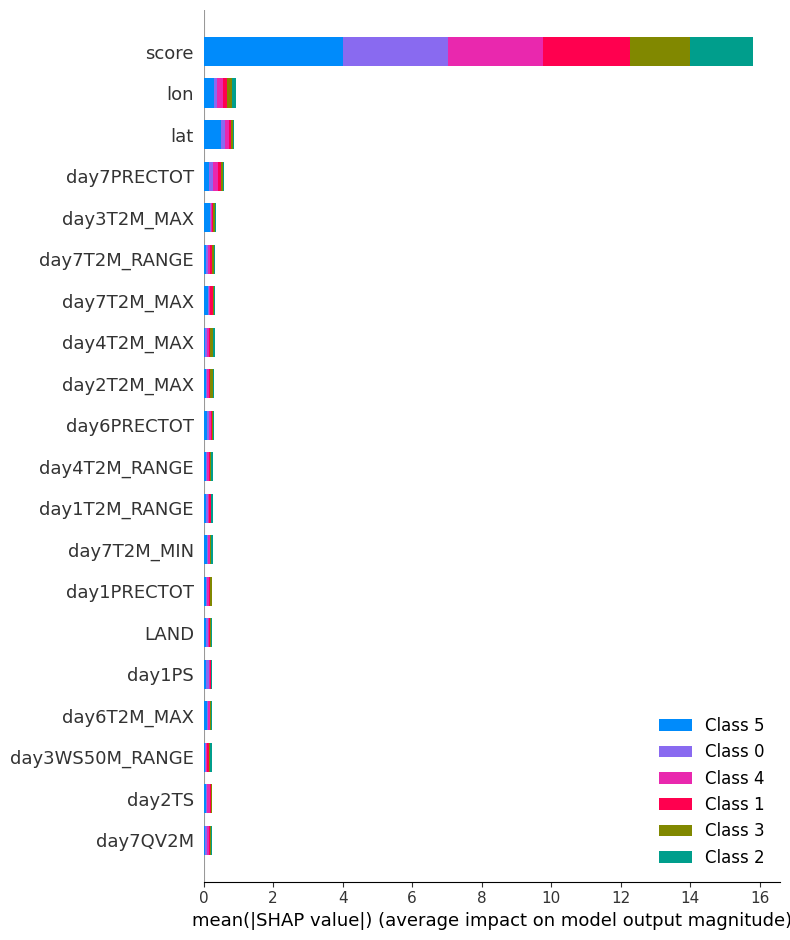

In [61]:
# 학습데이터 summary_plot
shap.summary_plot(shap_values_train, train_X)

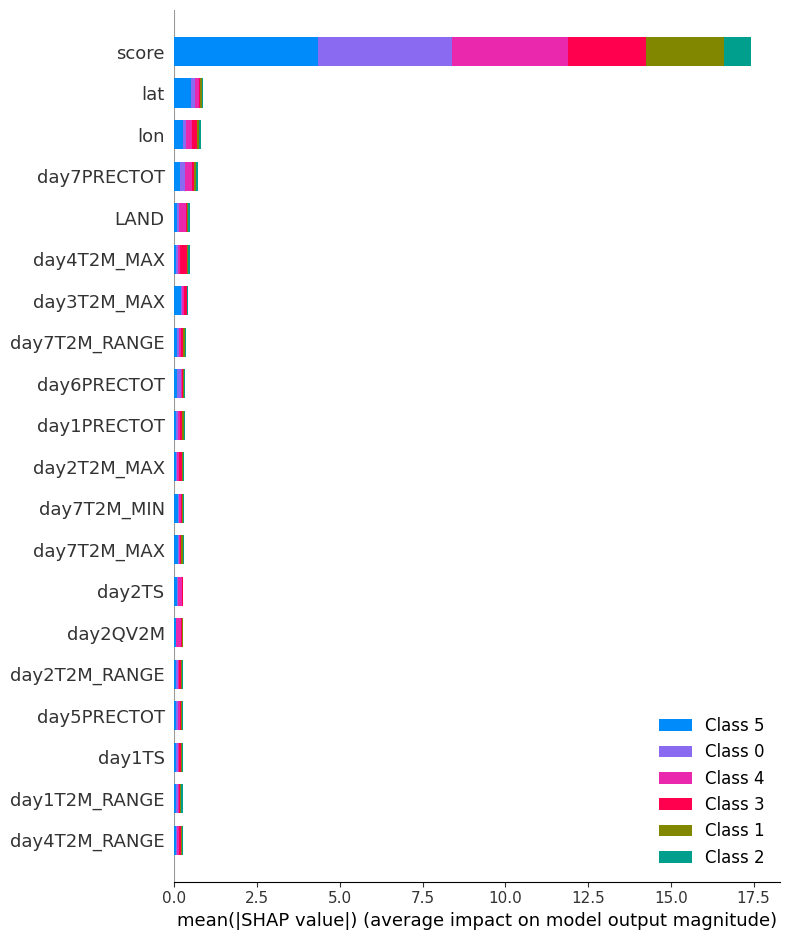

In [62]:
# test 데이터 summary_plot
shap.summary_plot(shap_values_test, test_X)